In [1]:
#80
#途中まで50と同じ

#データダウンロード
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip NewsAggregatorDataset.zip

--2022-01-29 06:31:33--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  15.7MB/s    in 1.8s    

2022-01-29 06:31:35 (15.7 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [2]:
# 読込時のエラー回避のためダブルクォーテーションをシングルクォーテーションに置換
!sed -e 's/"/'\''/g' ./newsCorpora.csv > ./newsCorpora_re.csv

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# データの読込
df = pd.read_csv('./newsCorpora_re.csv', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP']) #具体例からこのように分ける

# データの抽出
df = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']] #publisherが”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”であるものの、そのカテゴリ名と記事見出しを抽出 isin https://vector-ium.com/pandas-isin/  loc(列ラベル) https://note.nkmk.me/python-pandas-at-iat-loc-iloc/

# データの分割
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42, stratify=df['CATEGORY']) #学習データ80%とその他20%に分ける train_test_splitについて https://qiita.com/KyleKatarn/items/2afa6787f04f28e2cd2d
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=42, stratify=valid_test['CATEGORY']) #その他に分けられたデータを半分ずつ検証データと評価データに分類(全体から見ると10%,10%)

train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)


# データの保存
train.to_csv('./train.txt', sep='\t', index=False)
valid.to_csv('./valid.txt', sep='\t', index=False)
test.to_csv('./test.txt', sep='\t', index=False)

# 事例数の確認
print('【学習データ】')
print(train['CATEGORY'].value_counts())
print('【検証データ】')
print(valid['CATEGORY'].value_counts())
print('【評価データ】')
print(test['CATEGORY'].value_counts())

【学習データ】
b    4501
e    4235
t    1220
m     728
Name: CATEGORY, dtype: int64
【検証データ】
b    563
e    529
t    153
m     91
Name: CATEGORY, dtype: int64
【評価データ】
b    563
e    530
t    152
m     91
Name: CATEGORY, dtype: int64


In [4]:
from collections import defaultdict
import string

# 単語の頻度集計
d = defaultdict(int)
table = str.maketrans(string.punctuation, ' '*len(string.punctuation))  # 記号をスペースに置換するテーブル
for text in train['TITLE']:
  for word in text.translate(table).split():
    d[word] += 1
d = sorted(d.items(), key=lambda x:x[1], reverse=True)

# 単語ID辞書の作成
word2id = {word: i + 1 for i, (word, cnt) in enumerate(d) if cnt > 1}  # 出現頻度が2回以上の単語を登録

print(f'ID数: {len(set(word2id.values()))}\n')
print('---頻度上位20語---')
for key in list(word2id)[:20]:
    print(f'{key}: {word2id[key]} 出現回数:{d[word2id[key]-1][1]}')

ID数: 9374

---頻度上位20語---
to: 1 出現回数:2141
s: 2 出現回数:1907
in: 3 出現回数:1423
UPDATE: 4 出現回数:1074
on: 5 出現回数:1065
as: 6 出現回数:1018
US: 7 出現回数:998
The: 8 出現回数:975
of: 9 出現回数:967
for: 10 出現回数:942
1: 11 出現回数:860
To: 12 出現回数:737
2: 13 出現回数:678
the: 14 出現回数:611
and: 15 出現回数:577
In: 16 出現回数:509
Of: 17 出現回数:478
at: 18 出現回数:466
a: 19 出現回数:449
A: 20 出現回数:442


# defaultdict
https://qiita.com/xza/items/

In [5]:
def tokenizer(text, word2id=word2id, unk=0):
  """ 入力テキストをスペースで分割しID列に変換(辞書になければunkで指定した数字を設定)"""
  table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  return [word2id.get(word, unk) for word in text.translate(table).split()]

In [6]:
#確認
text = train.iloc[0, train.columns.get_loc('TITLE')]
print(f'テキスト: {text}')
print(f'ID列: {tokenizer(text)}')

テキスト: UPDATE 1-Sandwich chain Quiznos files for bankruptcy protection
ID列: [4, 11, 0, 1717, 0, 790, 10, 1238, 3532]


In [7]:
#81
import torch
from torch import nn

class RNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.rnn = nn.RNN(emb_size, hidden_size, nonlinearity='tanh', batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)
    
  def forward(self, x):
    self.batch_size = x.size()[0]
    hidden = self.init_hidden()  # h0のゼロベクトルを作成
    emb = self.emb(x)
    # emb.size() = (batch_size, seq_len, emb_size)
    out, hidden = self.rnn(emb, hidden)
    # out.size() = (batch_size, seq_len, hidden_size)
    out = self.fc(out[:, -1, :])
    # out.size() = (batch_size, output_size)
    return out
    
  def init_hidden(self):
    hidden = torch.zeros(1, self.batch_size, self.hidden_size)
    return hidden

In [8]:
from torch.utils.data import Dataset

class CreateDataset(Dataset):
  def __init__(self, X, y, tokenizer):
    self.X = X
    self.y = y
    self.tokenizer = tokenizer

  def __len__(self):  # len(Dataset)で返す値を指定
    return len(self.y)

  def __getitem__(self, index):  # Dataset[index]で返す値を指定
    text = self.X[index]
    inputs = self.tokenizer(text)

    return {
      'inputs': torch.tensor(inputs, dtype=torch.int64),
      'labels': torch.tensor(self.y[index], dtype=torch.int64)
    }

In [9]:
# ラベルベクトルの作成
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
y_train = train['CATEGORY'].map(lambda x: category_dict[x]).values
y_valid = valid['CATEGORY'].map(lambda x: category_dict[x]).values
y_test = test['CATEGORY'].map(lambda x: category_dict[x]).values

# Datasetの作成
dataset_train = CreateDataset(train['TITLE'], y_train, tokenizer)
dataset_valid = CreateDataset(valid['TITLE'], y_valid, tokenizer)
dataset_test = CreateDataset(test['TITLE'], y_test, tokenizer)

print(f'len(Dataset)の出力: {len(dataset_train)}')
print('Dataset[index]の出力:')
for var in dataset_train[1]:
  print(f'  {var}: {dataset_train[1][var]}')

len(Dataset)の出力: 10684
Dataset[index]の出力:
  inputs: tensor([ 195,  557, 1078,  389, 3022,   87,  288,  605,   94,   41, 2657,  214])
  labels: 0


In [10]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1  # 辞書のID数 + パディングID
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 先頭10件の予測値取得
for i in range(10):
  X = dataset_train[i]['inputs']
  print(torch.softmax(model(X.unsqueeze(0)), dim=-1))

tensor([[0.2794, 0.1916, 0.2221, 0.3068]], grad_fn=<SoftmaxBackward>)
tensor([[0.3899, 0.0972, 0.1343, 0.3785]], grad_fn=<SoftmaxBackward>)
tensor([[0.1960, 0.1771, 0.2567, 0.3702]], grad_fn=<SoftmaxBackward>)
tensor([[0.2003, 0.2632, 0.3448, 0.1917]], grad_fn=<SoftmaxBackward>)
tensor([[0.2190, 0.3180, 0.2614, 0.2016]], grad_fn=<SoftmaxBackward>)
tensor([[0.2718, 0.3177, 0.1852, 0.2253]], grad_fn=<SoftmaxBackward>)
tensor([[0.2846, 0.2160, 0.2381, 0.2613]], grad_fn=<SoftmaxBackward>)
tensor([[0.2822, 0.2956, 0.2293, 0.1929]], grad_fn=<SoftmaxBackward>)
tensor([[0.2379, 0.1790, 0.2993, 0.2838]], grad_fn=<SoftmaxBackward>)
tensor([[0.2166, 0.2966, 0.2062, 0.2806]], grad_fn=<SoftmaxBackward>)


In [11]:
#82
from torch.utils.data import DataLoader
import time
from torch import optim

def calculate_loss_and_accuracy(model, dataset, device=None, criterion=None):
  """損失・正解率を計算"""
  dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for data in dataloader:
      # デバイスの指定
      inputs = data['inputs'].to(device)
      labels = data['labels'].to(device)

      # 順伝播
      outputs = model(inputs)

      # 損失計算
      if criterion != None:
        loss += criterion(outputs, labels).item()

      # 正解率計算
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return loss / len(dataset), correct / total


def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, collate_fn=None, device=None):
  """モデルの学習を実行し、損失・正解率のログを返す"""
  # デバイスの指定
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
  dataloader_valid = DataLoader(dataset_valid, batch_size=1, shuffle=False)

  # スケジューラの設定
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=1e-5, last_epoch=-1)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for data in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      inputs = data['inputs'].to(device)
      labels = data['labels'].to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # 評価モードに設定
    model.eval()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, dataset_train, device, criterion=criterion)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, dataset_valid, device, criterion=criterion)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

    # 検証データの損失が3エポック連続で低下しなかった場合は学習終了
    if epoch > 2 and log_valid[epoch - 3][0] <= log_valid[epoch - 2][0] <= log_valid[epoch - 1][0] <= log_valid[epoch][0]:
      break

    # スケジューラを1ステップ進める
    scheduler.step()

  return {'train': log_train, 'valid': log_valid}

In [12]:
import numpy as np
from matplotlib import pyplot as plt

def visualize_logs(log):
  fig, ax = plt.subplots(1, 2, figsize=(15, 5))
  ax[0].plot(np.array(log['train']).T[0], label='train')
  ax[0].plot(np.array(log['valid']).T[0], label='valid')
  ax[0].set_xlabel('epoch')
  ax[0].set_ylabel('loss')
  ax[0].legend()
  ax[1].plot(np.array(log['train']).T[1], label='train')
  ax[1].plot(np.array(log['valid']).T[1], label='valid')
  ax[1].set_xlabel('epoch')
  ax[1].set_ylabel('accuracy')
  ax[1].legend()
  plt.show()

In [13]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1 
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 1e-3
BATCH_SIZE = 1
NUM_EPOCHS = 10

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS)

epoch: 1, loss_train: 1.1076, accuracy_train: 0.5270, loss_valid: 1.1404, accuracy_valid: 0.4813, 65.0056sec
epoch: 2, loss_train: 1.0178, accuracy_train: 0.5941, loss_valid: 1.0862, accuracy_valid: 0.5516, 66.8261sec
epoch: 3, loss_train: 0.8641, accuracy_train: 0.6793, loss_valid: 0.9685, accuracy_valid: 0.6475, 64.9102sec
epoch: 4, loss_train: 0.7234, accuracy_train: 0.7422, loss_valid: 0.8660, accuracy_valid: 0.6879, 65.3081sec
epoch: 5, loss_train: 0.6262, accuracy_train: 0.7748, loss_valid: 0.7730, accuracy_valid: 0.7320, 66.1642sec
epoch: 6, loss_train: 0.5583, accuracy_train: 0.7967, loss_valid: 0.7384, accuracy_valid: 0.7433, 65.1991sec
epoch: 7, loss_train: 0.5103, accuracy_train: 0.8121, loss_valid: 0.7010, accuracy_valid: 0.7545, 67.7587sec
epoch: 8, loss_train: 0.4804, accuracy_train: 0.8199, loss_valid: 0.6888, accuracy_valid: 0.7552, 64.9509sec
epoch: 9, loss_train: 0.4658, accuracy_train: 0.8238, loss_valid: 0.6758, accuracy_valid: 0.7665, 67.3342sec
epoch: 10, loss_tra

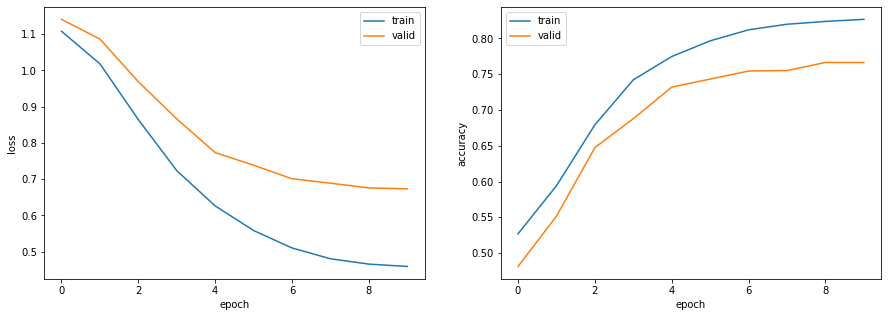

正解率（学習データ）：0.827
正解率（評価データ）：0.767


In [14]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

In [15]:
#83
#GPUに送るためにRNNを再定義する(hiddenが送れない)
class RNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size, device):
    super().__init__()
    self.hidden_size = hidden_size
    self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.rnn = nn.RNN(emb_size, hidden_size, nonlinearity='tanh', batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)
    self.device = device
    
  def forward(self, x):
    self.batch_size = x.size()[0]
    hidden = self.init_hidden().to(self.device)  # h0のゼロベクトルを作成
    emb = self.emb(x)
    # emb.size() = (batch_size, seq_len, emb_size)
    out, hidden = self.rnn(emb, hidden)
    # out.size() = (batch_size, seq_len, hidden_size)
    out = self.fc(out[:, -1, :])
    # out.size() = (batch_size, output_size)
    return out
    
  def init_hidden(self):
    hidden = torch.zeros(1, self.batch_size, self.hidden_size).to(self.device)
    return hidden

In [16]:
class Padsequence():
  """Dataloaderからミニバッチを取り出すごとに最大系列長でパディング"""
  def __init__(self, padding_idx):
    self.padding_idx = padding_idx

  def __call__(self, batch):
    sorted_batch = sorted(batch, key=lambda x: x['inputs'].shape[0], reverse=True)
    sequences = [x['inputs'] for x in sorted_batch]
    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=self.padding_idx)
    labels = torch.LongTensor([x['labels'] for x in sorted_batch])

    return {'inputs': sequences_padded, 'labels': labels}

## GPUの確認

In [17]:
!nvidia-smi

Sat Jan 29 06:42:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.00    Driver Version: 470.82.00    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN X ...  On   | 00000000:04:00.0 Off |                  N/A |
| 23%   22C    P8     8W / 250W |      8MiB / 12196MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA TITAN X ...  On   | 00000000:05:00.0 Off |                  N/A |
| 23%   

In [18]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

# デバイスの指定
device = torch.device('cuda')

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, device)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.2360, accuracy_train: 0.4323, loss_valid: 1.2332, accuracy_valid: 0.4469, 10.0815sec
epoch: 2, loss_train: 1.1461, accuracy_train: 0.5172, loss_valid: 1.1535, accuracy_valid: 0.5082, 9.9638sec
epoch: 3, loss_train: 1.0971, accuracy_train: 0.5684, loss_valid: 1.1331, accuracy_valid: 0.5292, 9.9802sec
epoch: 4, loss_train: 1.1323, accuracy_train: 0.5294, loss_valid: 1.1516, accuracy_valid: 0.5090, 9.9382sec
epoch: 5, loss_train: 1.1995, accuracy_train: 0.4824, loss_valid: 1.2447, accuracy_valid: 0.4521, 9.9739sec
epoch: 6, loss_train: 1.2114, accuracy_train: 0.4583, loss_valid: 1.2386, accuracy_valid: 0.4334, 9.9580sec
epoch: 7, loss_train: 1.1582, accuracy_train: 0.5067, loss_valid: 1.1900, accuracy_valid: 0.4790, 9.9376sec
epoch: 8, loss_train: 1.1334, accuracy_train: 0.5302, loss_valid: 1.1695, accuracy_valid: 0.4963, 9.9806sec
epoch: 9, loss_train: 1.1153, accuracy_train: 0.5473, loss_valid: 1.1529, accuracy_valid: 0.5150, 9.9693sec
epoch: 10, loss_train: 1.11

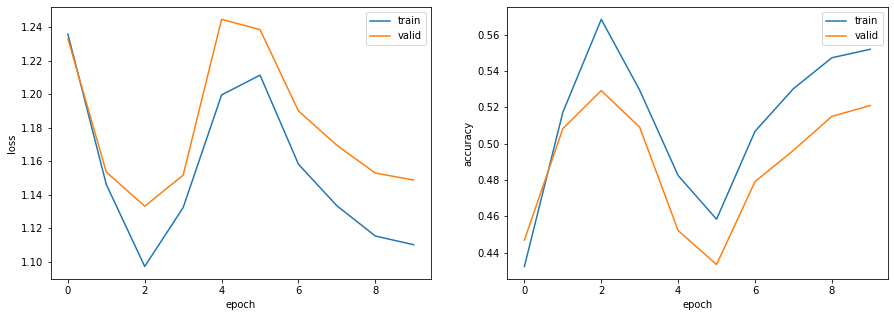

正解率（学習データ）：0.552
正解率（評価データ）：0.540


In [19]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

In [20]:
#84
!wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz

--2022-01-29 06:44:37--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.109.182
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.109.182|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  18.1MB/s    in 1m 40s  

2022-01-29 06:46:18 (15.7 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [21]:
!pip install gensim

distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None


In [22]:
from gensim.models import KeyedVectors

# 学習済みモデルのロード
model = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin.gz', binary=True)

# 学習済み単語ベクトルの取得
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
weights = np.zeros((VOCAB_SIZE, EMB_SIZE))
words_in_pretrained = 0
for i, word in enumerate(word2id.keys()):
  try:
    weights[i] = torch.tensor(model[word])
    words_in_pretrained += 1
  except KeyError:
    weights[i] = np.random.normal(scale=0.4, size=(EMB_SIZE,))
weights = torch.from_numpy(weights.astype((np.float32)))

print(f'学習済みベクトル利用単語数: {words_in_pretrained} / {VOCAB_SIZE}')
print(weights.size())

学習済みベクトル利用単語数: 9130 / 9375
torch.Size([9375, 300])


In [23]:
class RNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size, num_layers, device, emb_weights=None, bidirectional=False):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.num_directions = bidirectional + 1  # 単方向：1、双方向：2
    if emb_weights != None:  # 指定があれば埋め込み層の重みをemb_weightsで初期化
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.rnn = nn.RNN(emb_size, hidden_size, num_layers, nonlinearity='tanh', bidirectional=bidirectional, batch_first=True)
    self.fc = nn.Linear(hidden_size * self.num_directions, output_size)
    self.device = device

  def forward(self, x):
    self.batch_size = x.size()[0]
    hidden = self.init_hidden().to(self.device)  # h0のゼロベクトルを作成
    emb = self.emb(x)
    # emb.size() = (batch_size, seq_len, emb_size)
    out, hidden = self.rnn(emb, hidden)
    # out.size() = (batch_size, seq_len, hidden_size * num_directions)
    out = self.fc(out[:, -1, :])
    # out.size() = (batch_size, output_size)
    return out

  def init_hidden(self):
    hidden = torch.zeros(self.num_layers * self.num_directions, self.batch_size, self.hidden_size).to(self.device)
    return hidden

In [24]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 1
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

# デバイスの指定
device = torch.device('cuda')

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, device, emb_weights=weights)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.1692, accuracy_train: 0.4234, loss_valid: 1.1819, accuracy_valid: 0.4199, 10.1072sec
epoch: 2, loss_train: 1.1307, accuracy_train: 0.5212, loss_valid: 1.1677, accuracy_valid: 0.4843, 10.1044sec
epoch: 3, loss_train: 1.1898, accuracy_train: 0.5027, loss_valid: 1.2441, accuracy_valid: 0.4910, 10.1583sec
epoch: 4, loss_train: 1.0749, accuracy_train: 0.5862, loss_valid: 1.1040, accuracy_valid: 0.5591, 10.0912sec
epoch: 5, loss_train: 1.1118, accuracy_train: 0.5732, loss_valid: 1.1635, accuracy_valid: 0.5434, 10.2581sec
epoch: 6, loss_train: 1.0030, accuracy_train: 0.6432, loss_valid: 1.0434, accuracy_valid: 0.6025, 10.1207sec
epoch: 7, loss_train: 0.9676, accuracy_train: 0.6554, loss_valid: 1.0134, accuracy_valid: 0.6183, 10.1542sec
epoch: 8, loss_train: 0.9812, accuracy_train: 0.6498, loss_valid: 1.0339, accuracy_valid: 0.6070, 10.1413sec
epoch: 9, loss_train: 1.0021, accuracy_train: 0.6334, loss_valid: 1.0582, accuracy_valid: 0.6025, 11.7742sec
epoch: 10, loss_tra

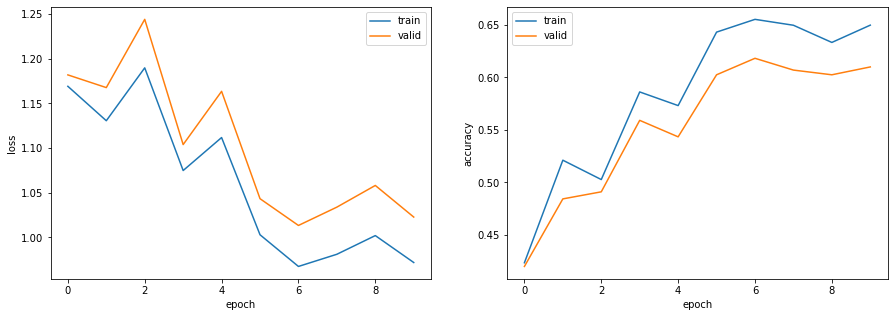

正解率（学習データ）：0.650
正解率（評価データ）：0.640


In [25]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')